In [111]:
# Install gdown if needed
!pip install -q gdown

import gdown, os

# Where everything will live
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("latent_checkpoints", exist_ok=True)

# -----------------------------
# Base models (trained classifiers)
# -----------------------------
base_models = {
    "mini_cnn_cifar10.pt": "1vBD0I0mBAgOb1zUxQxTpwrmj3LUvp6A1",
    "mini_resnet_cifar10.pt": "1iGI2UsYbEZdRln0kJ-lIZ5X4_Fv0NtUX",
}

# -----------------------------
# Autoencoders (latent codecs)
# -----------------------------
autoencoders = {
    "cnn_autoencoder.pt": "1glBo2IWxcNLmb4ZaWElsxvw7kKGAI3ba",
    "resnet_autoencoder.pt": "192bcpAi9iPI4jVkKpbOifmVPUStlRcyw",
}

def download_group(file_dict, out_dir):
    for name, fid in file_dict.items():
        out_path = os.path.join(out_dir, name)
        if os.path.exists(out_path):
            print(f"[exists] {out_path}")
            continue
        url = f"https://drive.google.com/uc?export=download&id={fid}"
        print(f"[downloading] {name}")
        gdown.download(url, out_path, quiet=False)

print("=== Downloading base models ===")
download_group(base_models, "checkpoints")

print("\n=== Downloading autoencoders ===")
download_group(autoencoders, "latent_checkpoints")

print("\nAll checkpoints ready.")

Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


=== Downloading base models ===
[exists] checkpoints/mini_cnn_cifar10.pt
[exists] checkpoints/mini_resnet_cifar10.pt

=== Downloading autoencoders ===
[exists] latent_checkpoints/cnn_autoencoder.pt
[exists] latent_checkpoints/resnet_autoencoder.pt

All checkpoints ready.


In [112]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [113]:
import torch.nn as nn



class MiniCNN(nn.Module):
    """
    Matches mini_cnn_cifar10.pt exactly:
      conv layers at net.0 and net.3
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # net.0
            nn.ReLU(inplace=True),                       # net.1
            nn.ReLU(inplace=True),                       # net.2 (no params)
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # net.3
            nn.ReLU(inplace=True),                       # net.4
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.net(x)
        x = self.pool(x)
        x = x.flatten(1)
        return self.fc(x)


class BasicBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c, c, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(c, c, 3, padding=1),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.block(x) + x)


class MiniResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.res1 = BasicBlock(16)
        self.res2 = BasicBlock(16)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16, 10)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.res1(x)
        x = self.res2(x)
        x = self.pool(x)
        x = x.flatten(1)
        return self.fc(x)

In [114]:
cnn = MiniCNN().to(device)
resnet = MiniResNet().to(device)

cnn.load_state_dict(torch.load("checkpoints/mini_cnn_cifar10.pt", map_location=device))
resnet.load_state_dict(torch.load("checkpoints/mini_resnet_cifar10.pt", map_location=device))

cnn.eval()
resnet.eval()

print("MiniCNN params:", sum(p.numel() for p in cnn.parameters()))
print("MiniResNet params:", sum(p.numel() for p in resnet.parameters()))

MiniCNN params: 20042
MiniResNet params: 9898


In [115]:
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
import numpy as np

transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

# small subset so landscapes are fast
rng = np.random.default_rng(0)
idx = rng.choice(len(testset), 100, replace=False)
testset = Subset(testset, idx.tolist())

loader = DataLoader(
    testset,
    batch_size=256,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

In [116]:
import math
from tqdm.auto import tqdm
import numpy as np

def select_weight_keys(model):
    return sorted(
        k for k, v in model.state_dict().items()
        if torch.is_tensor(v) and v.dim() >= 2
    )

def filter_normalize(direction, weights):
    out = {}
    eps = 1e-12
    for k in direction:
        d = direction[k]
        w = weights[k]
        d2 = d.reshape(d.shape[0], -1)
        w2 = w.reshape(w.shape[0], -1)
        d2 = d2 / (torch.norm(d2, dim=1, keepdim=True) + eps)
        d2 = d2 * torch.norm(w2, dim=1, keepdim=True)
        out[k] = d2.reshape_as(d)
    return out

@torch.no_grad()
def eval_loss(model, loader):
    loss_fn = nn.CrossEntropyLoss()
    total, n = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        total += loss_fn(model(x), y).item() * x.size(0)
        n += x.size(0)
    return total / n

In [117]:
def loss_landscape_original(
    model,
    x_spec="-1:1:31",
    y_spec="-1:1:31",
    logz=True,
):
    x = np.linspace(*map(float, x_spec.split(":")[:2]),
                    int(x_spec.split(":")[2]))
    y = np.linspace(*map(float, y_spec.split(":")[:2]),
                    int(y_spec.split(":")[2]))

    keys = select_weight_keys(model)
    theta = {k: v.clone().to(device) for k, v in model.state_dict().items() if k in keys}

    u = {k: torch.randn_like(v) for k, v in theta.items()}
    v = {k: torch.randn_like(v) for k, v in theta.items()}
    u = filter_normalize(u, theta)
    v = filter_normalize(v, theta)

    Z = np.zeros((len(x), len(y)))

    pbar = tqdm(total=len(x)*len(y))
    for i, a in enumerate(x):
        for j, b in enumerate(y):
            pert = {k: theta[k] + a*u[k] + b*v[k] for k in keys}
            full = model.state_dict()
            for k in pert:
                full[k] = pert[k]
            model.load_state_dict(full, strict=False)
            loss = eval_loss(model, loader)
            Z[i, j] = math.log(loss + 1e-12) if logz else loss
            pbar.update(1)
    pbar.close()
    return x, y, Z

In [118]:
x, y, Z_cnn = loss_landscape_original(
    cnn,
    x_spec="-500.0:500.0:51",
    y_spec="-500.0:500.0:51",
)

x, y, Z_resnet = loss_landscape_original(
    resnet,
    x_spec="-500.0:500.0:51",
    y_spec="-500.0:500.0:51",
)

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

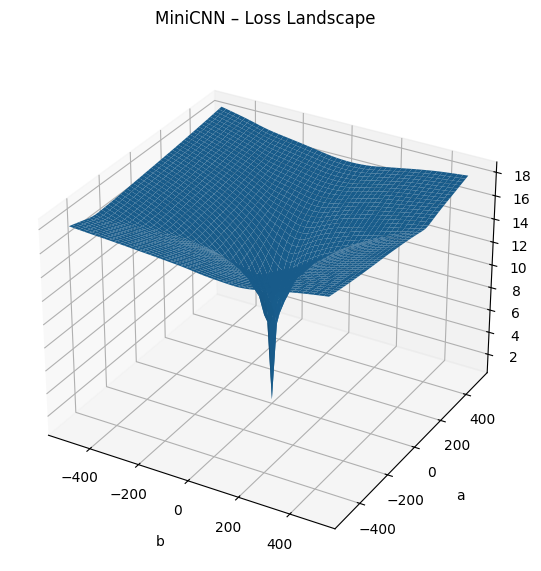

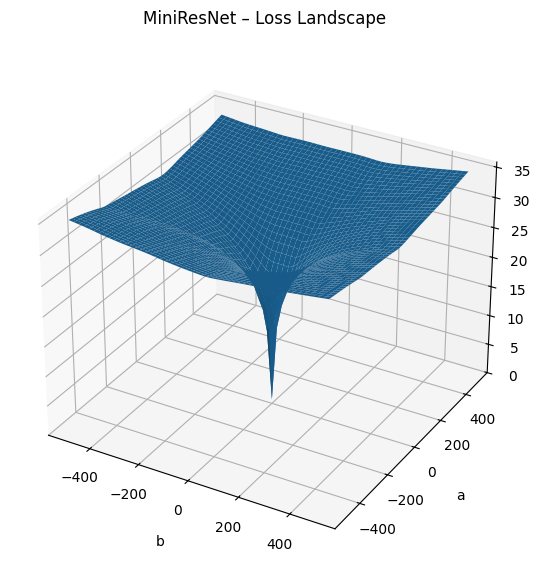

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import numpy as np

def plot_surface_3d(x, y, Z, title):
    X, Y = np.meshgrid(y, x)   # Z is [len(x), len(y)]

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot_surface(
        X, Y, Z,
        rstride=1,
        cstride=1,
        linewidth=0,
        antialiased=True
    )

    ax.set_title(title, pad=20)
    ax.set_xlabel("b", labelpad=10)
    ax.set_ylabel("a", labelpad=10)
    ax.set_zlabel("Loss", labelpad=20)
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.90)

    plt.show()

plot_surface_3d(x, y, Z_cnn, "MiniCNN – Loss Landscape")
plot_surface_3d(x, y, Z_resnet, "MiniResNet – Loss Landscape")

In [120]:


cnn_codec = torch.load("latent_checkpoints/cnn_autoencoder.pt")
resnet_codec = torch.load("latent_checkpoints/resnet_autoencoder.pt")

In [121]:
import torch.nn as nn
from typing import List

class Autoencoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        hidden_dims: List[int] = [128, 64]
    ):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU()
        )

        for i in range(len(hidden_dims)-1):
            self.encoder.append(nn.Linear(hidden_dims[i], hidden_dims[i-1]))
            self.encoder.append(nn.ReLU())

        self.encoder.append(nn.Linear(hidden_dims[-1], latent_dim))

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[-1]),
            nn.ReLU()
        )

        for i in range(len(hidden_dims)-1, 0, -1):
            self.decoder.append(nn.Linear(hidden_dims[i], hidden_dims[i-1]))
            self.decoder.append(nn.ReLU())

        self.decoder.append(nn.Linear(hidden_dims[0], input_dim))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))

In [122]:
class ParamVectorizer:
    def __init__(self, model):
        self.shapes = [p.shape for p in model.parameters()]
        self.sizes = [p.numel() for p in model.parameters()]
        self.numel = sum(self.sizes)

    def flatten(self, model):
        return torch.cat([p.detach().flatten() for p in model.parameters()])

    def load(self, vec, model):
        idx = 0
        for p, size, shape in zip(model.parameters(), self.sizes, self.shapes):
            p.data.copy_(vec[idx:idx+size].view(shape))
            idx += size

In [123]:
@torch.no_grad()
def eval_loss(model, loader, loss_fn):
    model.eval()
    total, n = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        loss = loss_fn(model(x), y)
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / n

In [124]:
import numpy as np
import math
from tqdm.auto import tqdm

def loss_landscape_ae(
    model,
    ae,                # autoencoder with encode / decode
    loader,
    x_spec="-0.3:0.3:51",
    y_spec="-0.3:0.3:51",
    logz=True,
):
    vec = ParamVectorizer(model)
    loss_fn = torch.nn.CrossEntropyLoss()

    # grid
    x = np.linspace(*map(float, x_spec.split(":")[:2]),
                    int(x_spec.split(":")[2]))
    y = np.linspace(*map(float, y_spec.split(":")[:2]),
                    int(y_spec.split(":")[2]))

    # base weights
    theta = vec.flatten(model).to(device)

    # encode once
    with torch.no_grad():
        z0 = ae.encode(theta.unsqueeze(0)).squeeze(0)

    # random latent directions
    u = torch.randn_like(z0)
    v = torch.randn_like(z0)
    u /= torch.norm(u)
    v /= torch.norm(v)

    Z = np.zeros((len(x), len(y)))

    pbar = tqdm(total=len(x) * len(y), desc="AE loss landscape")

    for i, a in enumerate(x):
        for j, b in enumerate(y):
            with torch.no_grad():
                z = z0 + a * u + b * v
                theta_ae = ae.decode(z.unsqueeze(0)).squeeze(0)

            # load decoded weights
            vec.load(theta_ae, model)

            loss = eval_loss(model, loader, loss_fn)
            Z[i, j] = math.log(loss + 1e-12) if logz else loss

            pbar.update(1)

    pbar.close()
    return x, y, Z

In [125]:
vec_cnn = ParamVectorizer(cnn)
P_cnn = vec_cnn.numel

cnn_latent_dim = 128
cnn_hidden_dims = [256]
cnn_codec = Autoencoder(
    input_dim=P_cnn,
    latent_dim=cnn_latent_dim,   # <-- MUST match training
    hidden_dims=[256]         # <-- MUST match training
).to(device)

cnn_codec.load_state_dict(
    torch.load("latent_checkpoints/cnn_autoencoder.pt", map_location=device)
)
cnn_codec.eval()

print("CNN autoencoder loaded")

CNN autoencoder loaded


In [126]:
resnet_latent_dim = 128
resnet_hidden_dims = [256]

vec_resnet = ParamVectorizer(resnet)
P_resnet = vec_resnet.numel

resnet_codec = Autoencoder(
    input_dim=P_resnet,
    latent_dim=resnet_latent_dim,
    hidden_dims=resnet_hidden_dims
).to(device)

resnet_codec.load_state_dict(
    torch.load("latent_checkpoints/resnet_autoencoder.pt", map_location=device)
)
resnet_codec.eval()

print("ResNet autoencoder loaded")

ResNet autoencoder loaded


In [127]:
x, y, Z_cnn_ae = loss_landscape_ae(
    cnn,
    cnn_codec,
    loader,
    x_spec="-1500:1500:51",
    y_spec="-1500:1500:51",
)

AE loss landscape:   0%|          | 0/2601 [00:00<?, ?it/s]

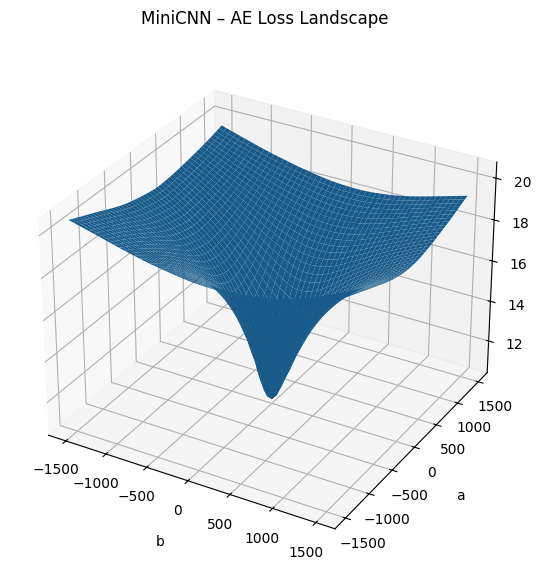

In [128]:
plot_surface_3d(x, y, Z_cnn_ae, "MiniCNN – AE Loss Landscape")

In [129]:
x, y, Z_resnet_ae = loss_landscape_ae(
    resnet,
    resnet_codec,
    loader,
    x_spec="-2000:2000:51",
    y_spec="-2000:2000:51",
)

AE loss landscape:   0%|          | 0/2601 [00:00<?, ?it/s]

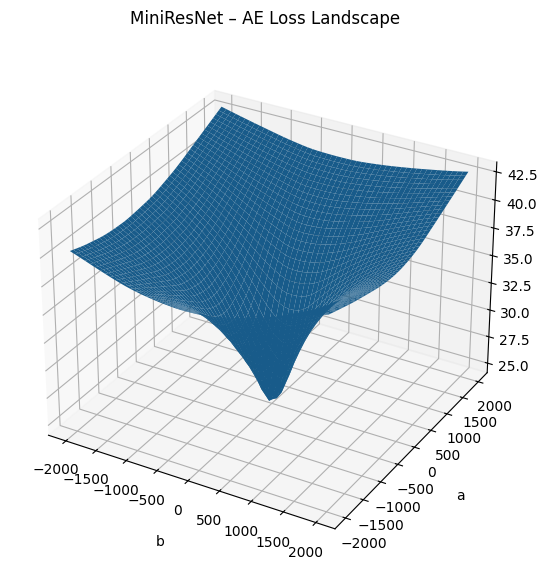

In [130]:
plot_surface_3d(x, y, Z_resnet_ae, "MiniResNet – AE Loss Landscape")

In [140]:

class ParamVectorizer:
    def __init__(self, model: nn.Module):
        self.params = [p for p in model.parameters() if p.requires_grad]
        self.shapes = [p.shape for p in self.params]
        self.sizes = [p.numel() for p in self.params]
        self.total = sum(self.sizes)

    def flatten_params(self) -> torch.Tensor:
        return torch.cat([p.detach().reshape(-1) for p in self.params], dim=0)

    def assign_params(self, vec: torch.Tensor) -> None:
        assert vec.numel() == self.total
        idx = 0
        for p, sz, sh in zip(self.params, self.sizes, self.shapes):
            p.data.copy_(vec[idx:idx+sz].view(sh))
            idx += sz
def hvp_on_batch(model: nn.Module, loss_fn: nn.Module, batch, v: torch.Tensor) -> torch.Tensor:
    x, y = batch
    model.zero_grad(set_to_none=True)

    logits = model(x)
    loss = loss_fn(logits, y)

    grads = torch.autograd.grad(
        loss,
        [p for p in model.parameters() if p.requires_grad],
        create_graph=True
    )

    g = torch.cat([gi.reshape(-1) for gi in grads], dim=0)
    gv = torch.dot(g, v)

    hv = torch.autograd.grad(
        gv,
        [p for p in model.parameters() if p.requires_grad],
        retain_graph=False
    )

    Hv = torch.cat([h.reshape(-1) for h in hv], dim=0).detach()
    return Hv

In [139]:
import math

@torch.no_grad()
def _normalize(v: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    return v / (v.norm() + eps)

def estimate_lambda_max(model, loss_fn, batch, n_iters=30) -> float:
    vec = ParamVectorizer(model)
    device = next(model.parameters()).device

    v = _normalize(torch.randn(vec.total, device=device))

    for _ in range(n_iters):
        Hv = hvp_on_batch(model, loss_fn, batch, v)
        v = _normalize(Hv)

    Hv = hvp_on_batch(model, loss_fn, batch, v)
    return float(torch.dot(v, Hv).item())

def estimate_lambda_min_shift(model, loss_fn, batch, lambda_max: float, n_iters=30) -> float:
    vec = ParamVectorizer(model)
    device = next(model.parameters()).device

    v = _normalize(torch.randn(vec.total, device=device))

    for _ in range(n_iters):
        Hv = hvp_on_batch(model, loss_fn, batch, v)
        v = _normalize(lambda_max * v - Hv)

    Hv = hvp_on_batch(model, loss_fn, batch, v)
    lam_Hprime_max = torch.dot(v, lambda_max * v - Hv).item()

    return lambda_max - lam_Hprime_max

In [141]:
def curvature_ratio_at_point(model, loader, loss_fn, n_iters=30, batch_limit=1):
    device = next(model.parameters()).device
    ratios = []

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        batch = (x, y)

        lam_max = estimate_lambda_max(model, loss_fn, batch, n_iters=n_iters)
        lam_min = estimate_lambda_min_shift(model, loss_fn, batch, lam_max, n_iters=n_iters)

        ratio = abs(lam_min) / (abs(lam_max) + 1e-12)
        ratios.append(ratio)

        if batch_limit is not None and i + 1 >= batch_limit:
            break

    return float(sum(ratios) / len(ratios))

@torch.no_grad()
def set_model_to_reconstruction(model, ae):
    vec = ParamVectorizer(model)
    theta = vec.flatten_params().to(next(model.parameters()).device)

    z = ae.encode(theta.unsqueeze(0))
    theta_rec = ae.decode(z).squeeze(0)

    vec.assign_params(theta_rec)

def compare_curvature_original_vs_recon(model, ae, loader, n_iters=30, batch_limit=1):
    loss_fn = nn.CrossEntropyLoss()
    vec = ParamVectorizer(model)

    theta0 = vec.flatten_params().clone()

    r_orig = curvature_ratio_at_point(
        model, loader, loss_fn, n_iters=n_iters, batch_limit=batch_limit
    )

    if ae is not None:
        set_model_to_reconstruction(model, ae)
        r_rec = curvature_ratio_at_point(
            model, loader, loss_fn, n_iters=n_iters, batch_limit=batch_limit
        )
        vec.assign_params(theta0)
    else:
        r_rec = None

    return r_orig, r_rec

In [142]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T

def disable_inplace_relu(model):
    for m in model.modules():
        if isinstance(m, torch.nn.ReLU):
            m.inplace = False

disable_inplace_relu(cnn)
disable_inplace_relu(resnet)
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
])

testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

test_loader = DataLoader(
    testset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn.to(device)
resnet.to(device)
cnn_codec.to(device)
resnet_codec.to(device)

r_cnn_orig, r_cnn_rec = compare_curvature_original_vs_recon(
    cnn, cnn_codec, test_loader, n_iters=80, batch_limit=10
)
r_res_orig, r_res_rec = compare_curvature_original_vs_recon(
    resnet, resnet_codec, test_loader, n_iters=80, batch_limit=10
)

print("MiniCNN   |λmin/λmax| original:", r_cnn_orig, "recon:", r_cnn_rec)
print("MiniResNet|λmin/λmax| original:", r_res_orig, "recon:", r_res_rec)

MiniCNN   |λmin/λmax| original: 1.689333481061892 recon: 0.9765749566441435
MiniResNet|λmin/λmax| original: 0.7281966963242421 recon: 0.7627618095594636
